# Fraud Detection in Electricity and Gas Consumption Challenge

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.

The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities. 

For more information about this challenge, click here: https://zindi.africa/competitions/fraud-detection-in-electricity-and-gas-consumption-challenge

Authors:
* Mila Miletic
* Jenny Louise 
* Sergio Sanz 


# Table of Contents
1. <a href=#import>Download and Extract Files</a>
2. <a href=#libraries>Import Libraries</a>
3. <a href=#functions>Useful Custom Functions</a>
4. <a href=#preparation>Data Preparation</a>
5. <a href=#fe>Feature Engineering</a>
6. <a href=#ml>ML Modeling</a>
7. <a href=#eval>Evaluation</a>

## Download and Extract Files
<a id='import'><a>

In [1]:
DATA_DIR = '/data'
TRAIN_DIR = f'{DATA_DIR}/train'
#TEST_DIR = f'{DATA_DIR}/test'
#OUTPUT_DIR = f'{DATA_DIR}/output'

In [2]:
#import os.path
#from os import path
#
#for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
#  if path.exists(pth) == False:
#    os.mkdir(pth)

In [3]:
#only run this cell once, at the start
#import requests, os
#
#train_zip = "train.zip"
#test_zip = "test.zip"
#sample_sub = "SampleSubmission.csv"

In [4]:
#!unzip "/content/train/train.zip" -d "/content/train/"
#!unzip "/content/test/test.zip" -d "/content/test/"

## Import Libraries
<a id='libraries'><a>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
#import lightgbm
#from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

# Modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, fbeta_score, make_scorer, confusion_matrix, classification_report, roc_curve
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, KNNImputer
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

import math

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

## Useful Custom Functions
<a id='functions'><a>

In [6]:
def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Traning data with labels or targets
    X_test            Testing data with features
    y_test            Testind data with labels or targets                             
    training=True     True: print scores on the traning set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Posible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the cunfusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
    
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
                 
        return fig, ax

    
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parametes "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary incluing hyperparameters
    X_train               #Training data with features
    y_train               #Traning data with labels or targets
    X_test                #Testing data with features
    y_test                #Testind data with labels or targets
    cv=5                  #Number of cross-validdation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the traning set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Posible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - fig, ax: the figure objects of the cunfusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    fig, ax = predict_and_print_scores(best_model,
                                       X_train,
                                       y_train,
                                       X_test,
                                       y_test,
                                       training=training,
                                       test=test,
                                       accuracy=accuracy,
                                       recall=recall,
                                       precision=precision,
                                       fbeta=fbeta,
                                       roc_auc=roc_auc,
                                       matrix=matrix,
                                       figsize=figsize,
                                       cmap=cmap)
    
    return best_model, best_params, fig, ax


def find_roc_threshold_tpr(model, X, y, value_target):
    
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target.
    
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    value_target          # False positive rate value
    
    Returns:
    
    threshold             # Threshold value
    false_positive_rate   # False positive rate value
    """

    fpr, tpr, thr = roc_curve(y, model.predict_proba(X)[:,1])

    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate


def find_roc_threshold_f1(model, X, y):
    
    """
    This function calculates the threshold in the ROC curve that maximizes the f1 score.
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    
    Returns:
    
    best_threshold        # Threshold value
    best_f1_score         # False positive rate value
    
    """
    
    pred_ = model.predict_proba(X)[:,1]

    best_threshold = 0.5
    best_f1_score = 0.0
    for value in np.arange(1, 10, 0.5):
        pred_tmp = np.where(pred_ >= float(value/10), 1, 0)
        cost = f1_score(y, pred_tmp)
        if cost > best_f1_score:
            best_f1_score = cost
            best_threshold = float(value/10)
      
    return best_threshold, best_f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
def plot_roc_curves(model_dic, X_test, y_test, figsize=(6,5)):

    """
    This function plots the ROC curves of the models defined in model_dic.
    The model_dic format is {'model_label' : [model_object, color-line'], ...}. Example:
    model_dic = {['model_1' : [model_1, 'r-'], 'model_2' : [model_2, 'b-']}
    """
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()

    for key, _ in model_dic.items():

        model = model_dic[key][0]

        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, model_dic[key][1], label=key)

    plt.plot([0,1],[0,1],'k:',label='Random')
    plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
    ax.set_xlabel('False Positive Rate (1 - Specifity)')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.legend()
    plt.grid()
    plt.show()

    return fig, ax

## Data Preparation
<a id='preparation'><a>

### Read the Data

In [7]:
client = pd.read_csv('data/train/client_train.csv', low_memory=False)
invoice = pd.read_csv('data/train/invoice_train.csv', low_memory=False)
#client_test = pd.read_csv('data/test/client_test.csv', low_memory=False)
#invoice_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False)

Columns:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0

- Tarif_type: Type of tax
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Months_number: Month number
- Counter_type: Type of counter

### Data Understanding

In [8]:
#compare size of the various datasets
print(client.shape, invoice.shape)

(135493, 6) (4476749, 16)


In [9]:
#print top rows of dataset
invoice.head(2)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC


In [10]:
client.head(2)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00


In [11]:
#Get a summary for all numerical columns
invoice.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,"4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00"
mean,20.13,"123,058,699,065.18",172.49,7.32,1.00,410.98,109.32,20.31,52.93,"17,767.00","18,349.70",44.83
std,13.47,"1,657,267,274,261.93",133.89,1.57,0.31,757.31,"1,220.12",157.42,875.47,"40,366.93","40,953.21","3,128.34"
min,8.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,11.00,"121,108.00",5.00,6.00,1.00,79.00,0.00,0.00,0.00,"1,791.00","2,056.00",4.00
50%,11.00,"494,561.00",203.00,8.00,1.00,274.00,0.00,0.00,0.00,"7,690.00","8,192.00",4.00
75%,40.00,"1,115,161.00",207.00,9.00,1.00,600.00,0.00,0.00,0.00,"21,660.00","22,343.00",4.00
max,45.00,"27,981,145,458,733.00",600.00,413.00,50.00,"999,910.00","999,073.00","64,492.00","547,946.00","2,800,280.00","2,870,972.00","636,624.00"


In [12]:
#Get a summary for all numerical columns
client.describe()

,disrict,client_catg,region,target
count,"135,493.00","135,493.00","135,493.00","135,493.00"
mean,63.51,11.51,206.16,0.06
std,3.35,4.42,104.21,0.23
min,60.00,11.00,101.00,0.00
25%,62.00,11.00,103.00,0.00
50%,62.00,11.00,107.00,0.00
75%,69.00,11.00,307.00,0.00
max,69.00,51.00,399.00,1.00


In [13]:
#Get concise information of each column in dataset
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [14]:
#Get concise information of each column in dataset
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [15]:
#Getting unique values on the invoice train data
for col in invoice.columns:
    print(f"{col} - {invoice[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [16]:
#Getting unique values on the invoice train data
for col in client.columns:
    print(f"{col} - {client[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [17]:
#check for missing values
invoice.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [18]:
#check for missing values
client.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

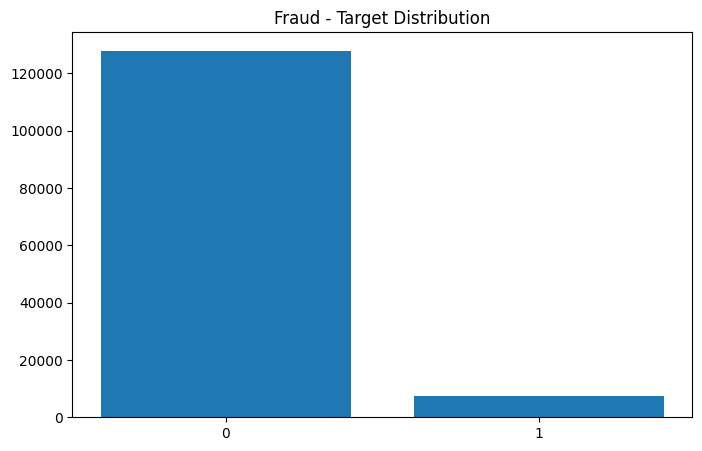

In [19]:
#Visualize fraudulent activities
fraudactivities = client.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

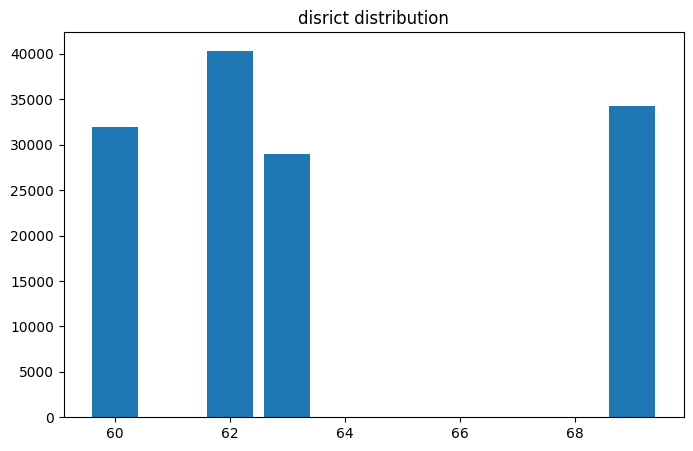

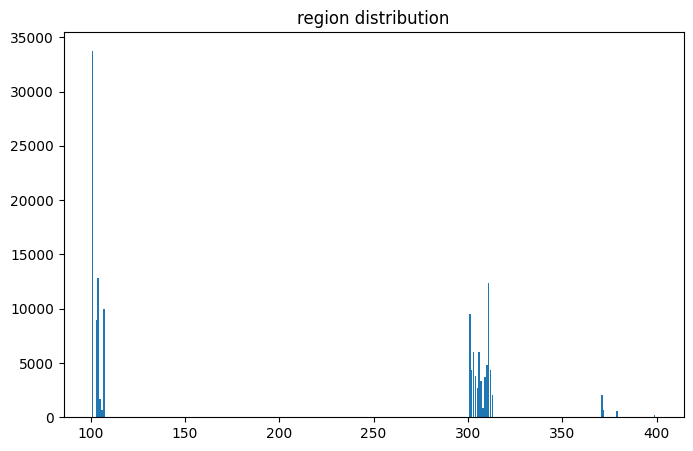

In [20]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering
<a id='fe'><a>

In [21]:
#rename columns
client.rename(columns={
    'disrict': 'district',
}, inplace=True)

invoice.rename(columns={
    'counter_statue': 'counter_status',
    'reading_remarque': 'agent_remark',
    # Add more columns as needed
}, inplace=True)

In [22]:
# List of columns to convert to categorical
columns_to_convert = ['tarif_type', 'counter_code', 'months_number', 'counter_type']

# Convert each column in invoice
for column in columns_to_convert:
    invoice[column] = invoice[column].astype('category')

In [23]:
# List of columns to convert to categorical
columns_to_convert = ['client_id', 'region','district']

# Convert each column in client
for column in columns_to_convert:
    client[column] = client[column].astype('category')

In [24]:
# Convert columns to integer, ensuring support for NaN values
columns_to_convert = ['target']

# Convert each column in client to a pandas nullable integer type
for column in columns_to_convert:
    client[column] = client[column].astype('int32')

In [25]:
# Change strings in counter_status to integers
def convert_to_int(value):
    # Check if the value is 'A' and return 500
    if value == 'A':
        return 500
    # Try to convert numeric strings directly to int
    try:
        return int(value)
    # If conversion fails (which shouldn't happen with the given conditions), return the value
    except ValueError:
        return value
    
invoice['counter_status'] = invoice['counter_status'].apply(convert_to_int)

In [26]:
# convert columns to integer, ensuring support for NaN values
columns_to_convert = ['counter_status','counter_code']

# Convert each column in client to a pandas nullable integer type
for column in columns_to_convert:
    invoice[column] = invoice[column].astype('int32')

In [27]:
#Change date to datetime
client['creation_date'] = pd.to_datetime(client['creation_date'])

#Change date to datetime
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'])

In [28]:
# calculate total consumption per billing cycle per counter type
invoice['total_consumption'] = invoice[['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']].sum(axis=1)

In [29]:
# Then, aggregate total_consumption by client_id
aggregated_consumption_ener = invoice.groupby('client_id')['total_consumption'].agg(
    ener_total_consumption='sum',  # Aggregate the total
    ener_min_consumption='min',
    ener_max_consumption='max',
    ener_mean_consumption='mean',
    ener_std_consumption='std',
    ener_range_consumption=lambda x: x.max() - x.min()  # Calculate the range as max - min
).reset_index()

In [30]:
# Filter the DataFrame for rows where 'counter_type' is 'GAZ'
###invoice_gas = invoice[invoice['counter_type'] == 'GAZ']

# Then, aggregate total_consumption by client_id and counter type (which is now only 'ELEC')
###aggregated_consumption_gas = invoice_gas.groupby('client_id')['total_consumption'].agg(
  ###  gas_total_consumption='sum',  # Aggregate the total
  ###  gas_min_consumption='min',
  ###  gas_max_consumption='max',
  ###  gas_mean_consumption='mean',
  ###  gas_std_consumption='std',
    #gas_range_consumption=lambda x: x.max() - x.min()  # Calculate the range as max - min
###).reset_index()

# Display the aggregated consumption for 'ELEC' counter type
#aggregated_consumption_gas

In [31]:
invoice['invoice_month'] = invoice['invoice_date'].dt.month
invoice['invoice_year'] = invoice['invoice_date'].dt.year

In [32]:
# Assuming 'invoice' DataFrame is already filtered for 'ELEC' counter type
# invoice_elec = invoice[invoice['counter_type'] == 'ELEC']

# Then, aggregate consumption by client_id for each consumption level separately
aggregated_consumption_ener_1 = invoice.groupby('client_id')['consommation_level_1'].agg(
    cons1_total='sum',
    cons1_min='min',
    cons1_max='max',
    cons1_mean='mean',
    cons1_std='std',
    cons1_range=lambda x: x.max() - x.min()
).reset_index()

aggregated_consumption_ener_2 = invoice.groupby('client_id')['consommation_level_2'].agg(
    cons2_total='sum',
    cons2_min='min',
    cons2_max='max',
    cons2_mean='mean',
    cons2_std='std',
    cons2_range=lambda x: x.max() - x.min()
).reset_index()

aggregated_consumption_ener_3 = invoice.groupby('client_id')['consommation_level_3'].agg(
    cons3_total='sum',
    cons3_min='min',
    cons3_max='max',
    cons3_mean='mean',
    cons3_std='std',
    cons3_range=lambda x: x.max() - x.min()
).reset_index()

aggregated_consumption_ener_4 = invoice.groupby('client_id')['consommation_level_4'].agg(
    cons4_total='sum',
    cons4_min='min',
    cons4_max='max',
    cons4_mean='mean',
    cons4_std='std',
    cons4_range=lambda x: x.max() - x.min()
).reset_index()

In [33]:
# Replace values of counter_status
invoice['counter_status'] = invoice['counter_status'].replace(500, 6)
invoice['counter_status'] = invoice['counter_status'].replace(769, 7)
invoice['counter_status'] = invoice['counter_status'].replace(618, 8)
invoice['counter_status'] = invoice['counter_status'].replace(269375, 9)
invoice['counter_status'] = invoice['counter_status'].replace(46, 10)
invoice['counter_status'] = invoice['counter_status'].replace(420, 11)

In [34]:
# Aggretate counter_status by client_id
aggregated_counter_status = invoice.groupby('client_id')['counter_status'].agg(
    counter_status_min='min',
    counter_status_max='max',
    counter_status_mean='mean',
    counter_status_std='std',
).reset_index()

In [35]:
# Replace values of agent_remark
invoice['agent_remark'] = invoice['agent_remark'].replace(5, 1)
invoice['agent_remark'] = invoice['agent_remark'].replace(6, 2)
invoice['agent_remark'] = invoice['agent_remark'].replace(7, 3)
invoice['agent_remark'] = invoice['agent_remark'].replace(8, 4)
invoice['agent_remark'] = invoice['agent_remark'].replace(9, 5)
invoice['agent_remark'] = invoice['agent_remark'].replace(203, 6)
invoice['agent_remark'] = invoice['agent_remark'].replace(207, 7)
invoice['agent_remark'] = invoice['agent_remark'].replace(413, 8)

In [36]:
# Aggretate agent_remark by client_id
aggregated_agent_remark = invoice.groupby('client_id')['agent_remark'].agg(
    agent_remark_min='min',
    agent_remark_max='max',
    agent_remark_mean='mean',
    agent_remark_std='std',
    #agent_remark_mode='mode'
).reset_index()

In [37]:
# Aggretate counter_coefficient by client_id
aggregated_counter_coefficient = invoice.groupby('client_id')['counter_coefficient'].agg(
    counter_coefficient_min='min',
    counter_coefficient_max='max',
    counter_coefficient_mean='mean',
    counter_coefficient_std='std',
   # counter_coefficient_remark_mode='mode'
).reset_index()

In [38]:
# Aggregate countet_code by client_id
aggregated_counter_code = invoice.groupby('client_id')['counter_code'].agg(
    counter_code_min='min',
    counter_code_max='max',
    counter_code_mean='mean',
    counter_code_std='std',
   # counter_coefficient_remark_mode='mode'
).reset_index()

In [39]:
# Create transaction_count feature
grouped_counts = invoice.groupby('client_id').size().reset_index(name='transaction_count')

In [40]:
# Sort invoice DataFrame by 'client_id', 'counter_type', and 'invoice_date'
invoice_sorted = invoice.sort_values(['client_id', 'counter_type', 'invoice_date'])

# Calculate the difference in days between invoice dates within each group of 'client_id' and 'counter_type'
invoice_sorted['invoice_delta_time'] = invoice_sorted.groupby(['client_id', 'counter_type'])['invoice_date'].diff().dt.days

# Create a new DataFrame focusing on the columns of interest
date_eda = invoice_sorted[['client_id', 'counter_type', 'invoice_date', 'invoice_delta_time']].copy()

# Sort this new DataFrame by 'client_id', 'counter_type', and 'invoice_date'
date_eda_sorted = date_eda.sort_values(['client_id', 'counter_type', 'invoice_date'])

In [41]:
# Sort invoice DataFrame by 'client_id' and 'invoice_date'
invoice_sorted = invoice.sort_values(['client_id', 'invoice_date'])

# Calculate the difference in days between invoice dates within each group of 'client_id' and 'counter_type'
invoice_sorted['invoice_delta_time'] = invoice_sorted.groupby(['client_id'])['invoice_date'].diff().dt.days

# Create a new DataFrame focusing on the columns of interest
date_eda = invoice_sorted[['client_id', 'invoice_date', 'invoice_delta_time']].copy()

# Sort this new DataFrame by 'client_id', 'counter_type', and 'invoice_date'
date_eda_sorted = date_eda.sort_values(['client_id', 'invoice_date'])

In [42]:
# Filter the DataFrame for rows where 'counter_type' is 'ELEC'
#date_elec = date_eda_sorted[date_eda_sorted['counter_type'] == 'ELEC' AND date_eda_sorted['counter_type'] == 'GAZ']

# Group by 'client_id' and then calculate the aggregate statistics for 'invoice_delta_time'
aggregated_ener_date_stats = date_eda_sorted.groupby(['client_id'])['invoice_delta_time'].agg(
    ener_min_invoice_delta='min',
    ener_max_invoice_delta='max',
    ener_mean_invoice_delta='mean',
    #elec_median_invoice_delta='median',
    ener_std_invoice_delta='std'
).reset_index()

In [43]:
# Filter the DataFrame for rows where 'counter_type' is 'GAZ'
###date_gas = date_eda_sorted[date_eda_sorted['counter_type'] == 'GAZ']

# Group by both 'client_id' and 'counter_type', then calculate the aggregate statistics for 'invoice_delta_time'
###aggregated_gas_date_stats = date_gas.groupby(['client_id'])['invoice_delta_time'].agg(
###    gas_min_invoice_delta='min',
###    gas_max_invoice_delta='max',
###    gas_mean_invoice_delta='mean',
    #gas_median_invoice_delta='median',
###    gas_std_invoice_delta='std'
###).reset_index()

In [44]:
# List of columns you want to include in the new DataFrame
columns_to_include = ['client_id', 'client_catg', 'region', 'creation_date', 'target']

# Create a new DataFrame with the specified columns
model_df = client[columns_to_include].copy()

In [45]:
# Create the whole dataframe
model_df = model_df.merge(aggregated_counter_status[['client_id',
                                                     'counter_status_min',
                                                     'counter_status_max',
                                                     'counter_status_mean',
                                                     'counter_status_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_agent_remark[['client_id',
                                                   'agent_remark_min',
                                                   'agent_remark_max',
                                                   'agent_remark_mean',
                                                   'agent_remark_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_counter_coefficient[['client_id',
                                                          'counter_coefficient_min',
                                                          'counter_coefficient_max',
                                                          'counter_coefficient_mean',
                                                          'counter_coefficient_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_counter_code[['client_id',
                                                          'counter_code_min',
                                                          'counter_code_max',
                                                          'counter_code_mean',
                                                          'counter_code_std']], on='client_id', how='left')

model_df = model_df.merge(grouped_counts[['client_id','transaction_count']], on='client_id', how='left')

In [46]:
model_df = model_df.merge(aggregated_consumption_ener[['client_id',
                                                       'ener_total_consumption',
                                                       'ener_min_consumption',
                                                       'ener_max_consumption',
                                                       'ener_mean_consumption',
                                                       'ener_std_consumption']], on='client_id', how='left')

model_df = model_df.merge(aggregated_ener_date_stats[['client_id',
                                                      'ener_min_invoice_delta',
                                                      'ener_max_invoice_delta',
                                                      'ener_mean_invoice_delta',
                                                      'ener_std_invoice_delta']], on='client_id', how='left')

model_df = model_df.merge(aggregated_consumption_ener_1[['client_id', 
                                                         'cons1_total', 
                                                         'cons1_min', 
                                                         'cons1_max', 
                                                         'cons1_mean', 
                                                         'cons1_std', 
                                                         'cons1_range']], on='client_id', how='left')


model_df = model_df.merge(aggregated_consumption_ener_2[['client_id', 
                                                         'cons2_total', 
                                                         'cons2_min', 
                                                         'cons2_max', 
                                                         'cons2_mean', 
                                                         'cons2_std', 
                                                         'cons2_range']], on='client_id', how='left')


model_df = model_df.merge(aggregated_consumption_ener_3[['client_id', 
                                                         'cons3_total', 
                                                         'cons3_min', 
                                                         'cons3_max', 
                                                         'cons3_mean', 
                                                         'cons3_std', 
                                                         'cons3_range']], on='client_id', how='left')


model_df = model_df.merge(aggregated_consumption_ener_4[['client_id', 
                                                         'cons4_total', 
                                                         'cons4_min', 
                                                         'cons4_max', 
                                                         'cons4_mean', 
                                                         'cons4_std', 
                                                         'cons4_range']], on='client_id', how='left')

In [47]:
# Compute contract duration
model_df['coop_time'] = (2019 - model_df['creation_date'].dt.year)*12 - model_df['creation_date'].dt.month

In [48]:
# Compute invoice per cooperation
model_df['invoice_per_cooperation'] = model_df['transaction_count'] / model_df['coop_time']
model_df['invoice_per_cooperation'].replace([np.inf, -np.inf], 0, inplace=True)

In [49]:
model_df.head()

,client_id,client_catg,region,creation_date,target,counter_status_min,counter_status_max,counter_status_mean,counter_status_std,agent_remark_min,...,cons3_std,cons3_range,cons4_total,cons4_min,cons4_max,cons4_mean,cons4_std,cons4_range,coop_time,invoice_per_cooperation
0,train_Client_0,11,101,1994-12-31,0,0,0,0.00,0.00,2,...,0.00,0,0,0,0,0.00,0.00,0,288,0.12
1,train_Client_1,11,107,2002-05-29,0,0,0,0.00,0.00,2,...,0.00,0,0,0,0,0.00,0.00,0,199,0.19
2,train_Client_10,11,301,1986-03-13,0,0,0,0.00,0.00,2,...,0.00,0,0,0,0,0.00,0.00,0,393,0.05
3,train_Client_100,11,105,1996-07-11,0,0,0,0.00,0.00,2,...,0.00,0,0,0,0,0.00,0.00,0,269,0.07
4,train_Client_1000,11,303,2014-10-14,0,0,0,0.00,0.00,4,...,289.43,800,514,0,382,36.71,105.42,382,50,0.28


In [50]:
# Convert numerical features of type int64 to int32
for column in model_df.columns:
    if model_df[column].dtype == 'int64':
        model_df[column] = model_df[column].astype('int32')

## ML Modeling 
<a id='ml'><a>

In [51]:
# Drop redundant columns
model_df_copy = model_df.copy()
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in model_df_copy.columns:
        model_df_copy.drop([col], axis=1, inplace=True)

In [52]:
# Print the list of final features and their types
model_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   client_catg               135493 non-null  int32   
 1   region                    135493 non-null  category
 2   target                    135493 non-null  int32   
 3   counter_status_min        135493 non-null  int32   
 4   counter_status_max        135493 non-null  int32   
 5   counter_status_mean       135493 non-null  float64 
 6   counter_status_std        131281 non-null  float64 
 7   agent_remark_min          135493 non-null  int32   
 8   agent_remark_max          135493 non-null  int32   
 9   agent_remark_mean         135493 non-null  float64 
 10  agent_remark_std          131281 non-null  float64 
 11  counter_coefficient_min   135493 non-null  int32   
 12  counter_coefficient_max   135493 non-null  int32   
 13  counter_coefficient_mean  135

### Train - Test Split 

In [53]:
y = model_df_copy['target']
X = model_df_copy.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((108394, 54), (27099, 54))

### Build the Pipeline for Preprocessing

In [54]:
num_features = X_train.select_dtypes(include=['int32', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    remainder='passthrough')

### Logistic Regressor (Baseline)

In [55]:
model_lg = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('lg', LogisticRegression())
]) 

model_lg.fit(X_train, y_train)

predict_and_print_scores(model_lg, X_train, y_train, X_test, y_test, matrix=False)

Accuracy on training set: 0.88
Accuracy on test set: 0.88
----------------------------------------
Recall on training set: 0.22
Recall on test set: 0.22
----------------------------------------
Precision on training set: 0.15
Precision on test set: 0.15
----------------------------------------
fbeta_score on training set: 0.18
fbeta_score on test set: 0.18
----------------------------------------
roc_auc_score on trainig set:  0.68
roc_auc_score on test set:  0.69
----------------------------------------


### XGBoost Classifier with Full Grid Search

In [56]:
# Build the pipeline and train

#xgb_pipe = ImbPipeline([
#    ('prep', preprocessor),
#    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
#    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
#])

#hyperparameters = {
#    'xgb__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
#    'xgb__n_estimators': [100, 200, 500, 600],
#    'xgb__max_depth': [3, 5, 7, 10, 15, 20, 25],
#    'xgb__subsample': [0.5, 0.7, 1.0],
#    'xgb__colsample_bytree': [0.5, 0.7, 1.0]
#}

#model_xgb, params_xgb, _, _ = train_crossval_predict_score(
#    xgb_pipe,
#    hyperparameters,
#    X_train,
#    y_train,
#    X_test,
#    y_test,
#    cv=5,
#    scoring='f1',
#    verbose=0,
#    n_jobs=-1,
#    cross_val='full',
#    random_state=None,
#    training=True,
#    test=True,
#    accuracy=True,
#    recall=True,
#    precision=True,
#    fbeta=[True, 1.0],
#    roc_auc=True,
#    matrix=True,
#    figsize=(3,2),
#    cmap='YlGn')

Full Grid search:
Best params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 600, 'xgb__subsample': 0.7}

In [57]:
model_xgb = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('best_xgb', XGBClassifier(n_estimators=600, max_depth=7, learning_rate=0.01, colsample_bytree=1.0, subsample=0.7, use_label_encoder=False))
])

# Fit model
model_xgb.fit(X_train, y_train)

# Predict and score
predict_and_print_scores(model_xgb, X_train, y_train, X_test, y_test, matrix=False)

Accuracy on training set: 0.87
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 0.66
Recall on test set: 0.5
----------------------------------------
Precision on training set: 0.25
Precision on test set: 0.19
----------------------------------------
fbeta_score on training set: 0.36
fbeta_score on test set: 0.28
----------------------------------------
roc_auc_score on trainig set:  0.88
roc_auc_score on test set:  0.81
----------------------------------------


## Evaluation
<a id='eval'><a>

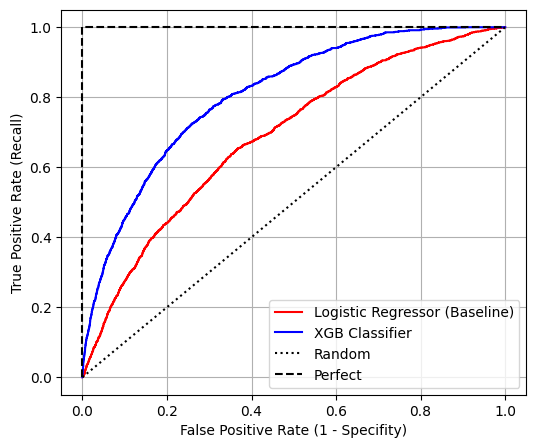

In [58]:
models = {'Logistic Regressor (Baseline)' : [model_lg, 'r-'], 'XGB Classifier' : [model_xgb, 'b-']}
fig, ax = plot_roc_curves(models, X_test, y_test)

In [59]:
# Find the threshold that maximizes f1 for final prediction
best_thr, score = find_roc_threshold_f1(model_xgb, X_test, y_test)
print(f"Best threshold: {round(best_thr, 2)}")
print(f"Best f1 score: {round(score, 2)}")

Best threshold: 0.6
Best f1 score: 0.29


In [60]:
# Find the false positive rate corresponding to a recall of 80%
thr_80, false_pos_rate = find_roc_threshold_tpr(model_xgb, X_test, y_test, 0.8)

print(f"Threshold for tpr of {round(thr_80, 2)}")
print(f"False positive rate: {round(false_pos_rate, 2)}")

Threshold for tpr of 0.3100000023841858
False positive rate: 0.34


Normalized confusion matrix
[[0.65809427 0.34190573]
 [0.20026438 0.79973562]]


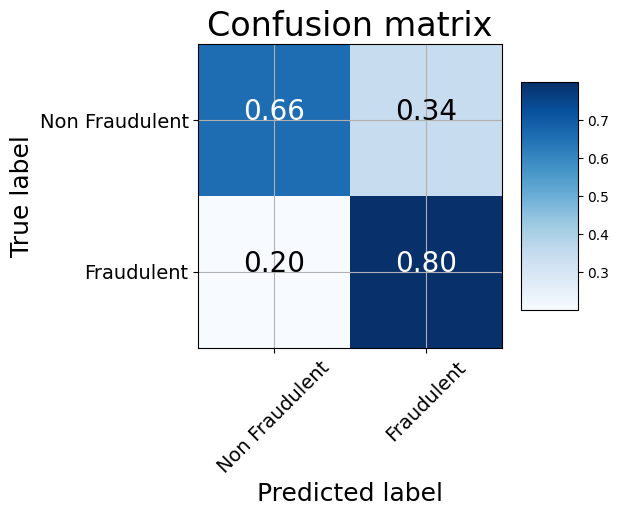

In [61]:
# Plot confusion matrix on the test set
y_test_pred = model_xgb.predict_proba(X_test)[:,1] >= thr_80
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Non Fraudulent', 'Fraudulent'], normalize=True, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(6,6))

In [62]:
# Find out the most relevant features

# Get the XGB Classifier step from the pipeline
xgb_step = model_xgb.named_steps['best_xgb']

# Access feature importances
feature_importances = xgb_step.feature_importances_
feature_names = X_train.columns

# Combine feature names and their importances into a dictionary, then sort by importance
importances_dict = dict(zip(feature_names, feature_importances))
sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)

# Displaying feature importances
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {round(100 * importance, 2)}%")

Feature: cons3_std, Importance: 13.56%
Feature: transaction_count, Importance: 8.59%
Feature: cons4_std, Importance: 4.8%
Feature: cons2_std, Importance: 3.19%
Feature: ener_total_consumption, Importance: 2.69%
Feature: cons3_min, Importance: 2.21%
Feature: counter_code_max, Importance: 2.15%
Feature: counter_code_mean, Importance: 2.13%
Feature: invoice_per_cooperation, Importance: 2.13%
Feature: cons4_mean, Importance: 2.08%
Feature: cons4_min, Importance: 2.07%
Feature: cons3_max, Importance: 2.01%
Feature: cons1_max, Importance: 1.99%
Feature: counter_code_std, Importance: 1.99%
Feature: counter_code_min, Importance: 1.95%
Feature: cons2_range, Importance: 1.91%
Feature: counter_coefficient_std, Importance: 1.86%
Feature: cons4_max, Importance: 1.85%
Feature: cons3_range, Importance: 1.76%
Feature: counter_status_mean, Importance: 1.73%
Feature: cons2_min, Importance: 1.7%
Feature: agent_remark_max, Importance: 1.69%
Feature: counter_status_min, Importance: 1.69%
Feature: cons1_std